# Use Case Name : UC00204_Resilient_Education_Access

# Authored by: Ekanayake Mudiyanselage Ruvinya Yasasmee Ekanayake

Duration - 90 mins

Level - Intermediate

Pre-requisite Skills - Python, Pandas, Data visuaization, Data handling, Data cleaning

# Objective

Quantify and anticipate school-age (5-19) demand across the City of Melbourne, identify suburb-level capacity shortages and geographic resilience concerns from existing school sites, and create a clear, time-phased seats/schools build plan by target year.


# Datasets

1. School Locations Dataset (2024): Includes geographic details of schools in Melbourne.
Department of Education (Vic). (2024). School Locations—All Victorian schools (CSV). Victoria State Government – DataVic. https://www.education.vic.gov.au/Documents/about/research/datavic/dv378_DataVic-SchoolLocations-2024.csv




2. Population Forecasts Dataset (2020–2040): Provides suburb-level forecasts, including age groups and year-wise projections.
City of Melbourne. (2020–2040). Population forecasts by small area (API v2.1 CSV export). City of Melbourne Open Data. https://data.melbourne.vic.gov.au/api/v2/catalog/datasets/city-of-melbourne-population-forecasts-by-small-area-2020-2040/exports/csv?delimiter=%2C

## Imports

This imports cell loads the notebook's core tools: pandas and numpy for data manipulation and numerical work, matplotlib for quick visualizations, requests for fetching data from the web (API/CSV URLs), math for small numeric helpers and folium for optional map views using latitude/longitude. Collecting these up front ensures consistency in the environment and prevents dispersed, repeating imports later.

In [112]:
import pandas as pd
import numpy as np
import math
import requests
import matplotlib.pyplot as plt
import folium

Specifies the two hosted data sources: School Locations 2024 (supply) and City of Melbourne Population Forecasts 2020-2040 via API v2.1 (demand). Using URLs makes the notebook repeatable.

In [113]:

# School locations dataset
SCHOOLS_URL = "https://www.education.vic.gov.au/Documents/about/research/datavic/dv378_DataVic-SchoolLocations-2024.csv"

# Population forecast dataset
POP_URL = "https://data.melbourne.vic.gov.au/api/v2/catalog/datasets/city-of-melbourne-population-forecasts-by-small-area-2020-2040/exports/csv?delimiter=%2C"


## Loading datasets

Reads School Locations (CSV) and City of Melbourne Population Forecasts (API v2.1 CSV) into DataFrames. To handle special characters in the schools file, use ISO-8859-1, and set low_memory=False for reliable types. Prints raw shapes and displays the first six rows to ensure schema and connectivity.

In [114]:
# Read source data directly from the two URLs
school_df = pd.read_csv(SCHOOLS_URL, encoding="ISO-8859-1", low_memory=False)
pop_df = pd.read_csv(POP_URL, low_memory=False)

# Show row/column counts for both raw tables
print("Raw shapes:", school_df.shape, pop_df.shape)

# Quick peek at the first rows
display(school_df.head(6))
display(pop_df.head(6))


Raw shapes: (2294, 22) (10584, 5)


,Education_Sector,Entity_Type,School_No,School_Name,School_Type,Address_Line_1,Address_Line_2,Address_Town,Address_State,Address_Postcode,...,Postal_Town,Postal_State,Postal_Postcode,Full_Phone_No,Region_Name,AREA_Name,LGA_ID,LGA_Name,X,Y
0,Catholic,2,20,Parade College,Secondary,1436 Plenty Road,NaN,BUNDOORA,VIC,3083,...,BUNDOORA,VIC,3083.0,03 9468 3300,NORTH-WESTERN VICTORIA,North Eastern Melbourne,66,Banyule (C),145.06698,-37.69018
1,Catholic,2,25,Simonds Catholic College,Secondary,273 Victoria Street,NaN,WEST MELBOURNE,VIC,3003,...,WEST MELBOURNE,VIC,3003.0,03 9321 9200,SOUTH-WESTERN VICTORIA,Western Melbourne,460,Melbourne (C),144.95288,-37.80597
2,Catholic,2,26,St Marys College Melbourne,Secondary,11 Westbury Street,NaN,ST KILDA EAST,VIC,3183,...,ST KILDA,VIC,3182.0,03 9529 6611,SOUTH-EASTERN VICTORIA,Bayside Peninsula,590,Port Phillip (C),144.99700,-37.85936
3,Catholic,2,28,St Patrick's College Ballarat,Secondary,1431 Sturt Street,NaN,BALLARAT,VIC,3350,...,BALLARAT,VIC,3350.0,03 5331 1688,SOUTH-WESTERN VICTORIA,Central Highlands,57,Ballarat (C),143.83156,-37.55971
4,Catholic,2,29,St Patrick's School,Primary,119 Drummond Street South,NaN,BALLARAT,VIC,3350,...,BALLARAT WEST,VIC,3350.0,03 5332 7680,SOUTH-WESTERN VICTORIA,Central Highlands,57,Ballarat (C),143.84715,-37.56440
5,Catholic,2,30,St Alipius' Parish School,Primary,106-108 Victoria Street,NaN,BALLARAT EAST,VIC,3350,...,BALLARAT EAST,VIC,3350.0,03 5331 1816,SOUTH-WESTERN VICTORIA,Central Highlands,57,Ballarat (C),143.87401,-37.56170


,geography,year,gender,age,value
0,Carlton,2023,Female,Age 65-69,224
1,Carlton,2023,Female,Age 85+,66
2,Carlton,2024,Female,Age 25-29,2105
3,Carlton,2024,Female,Age 30-34,1174
4,Carlton,2024,Male,Age 25-29,1978
5,Carlton,2024,Male,Age 65-69,109


## Standardize column names for merging

Columns are renamed to a common schema for easier joins, including suburb (from Address_Town), lon and lat (from X and Y), and standard fields school_name, sector, school_type, lga, area, year, age_group, and population. Prints the revised column lists for verification.


In [115]:
# Schools: standardize / add suburb
school_df = school_df.rename(columns={
    "School_Name":"school_name",
    "Education_Sector":"sector",
    "School_Type":"school_type",
    "LGA_Name":"lga",
    "Address_Town":"suburb",   # will align with pop_df['area']
    "X":"lon",                 # longitude
    "Y":"lat"                  # latitude
})

# Population: standardize
pop_df = pop_df.rename(columns={
    "geography":"area",
    "year":"year",
    "age":"age_group",
    "value":"population"
})

# Check the new schemas
print("School cols:", school_df.columns.tolist())
print("Pop cols:", pop_df.columns.tolist())


School cols: ['sector', 'Entity_Type', 'School_No', 'school_name', 'school_type', 'Address_Line_1', 'Address_Line_2', 'suburb', 'Address_State', 'Address_Postcode', 'Postal_Address_Line_1', 'Postal_Address_Line_2', 'Postal_Town', 'Postal_State', 'Postal_Postcode', 'Full_Phone_No', 'Region_Name', 'AREA_Name', 'LGA_ID', 'lga', 'lon', 'lat']
Pop cols: ['area', 'year', 'gender', 'age_group', 'population']


## Data Cleaning

Schools

Selects relevant columns, converts lat/lon to numeric, removes invalid rows, normalizes text (strip + title-case), de-duplicates by name/LGA/suburb/coordinates, and outputs the cleaned shape and a preview.

In [116]:
# Keep only needed columns
school_df = school_df[["school_name","sector","school_type","lga","suburb","lat","lon"]].copy()

# Make coordinates numeric and drop rows without valid coordinates
school_df["lat"] = pd.to_numeric(school_df["lat"], errors="coerce")
school_df["lon"] = pd.to_numeric(school_df["lon"], errors="coerce")
school_df = school_df.dropna(subset=["lat","lon"])

# Normalize text
for c in ["school_name","sector","school_type","lga","suburb"]:
    school_df[c] = school_df[c].astype(str).str.strip().str.title()

# Remove duplicates (same school/location)
school_df = school_df.drop_duplicates(subset=["school_name","lga","suburb","lat","lon"])

print("Schools (clean):", school_df.shape)
display(school_df.head(3))


Schools (clean): (2293, 7)


,school_name,sector,school_type,lga,suburb,lat,lon
0,Parade College,Catholic,Secondary,Banyule (C),Bundoora,-37.69018,145.06698
1,Simonds Catholic College,Catholic,Secondary,Melbourne (C),West Melbourne,-37.80597,144.95288
2,St MaryS College Melbourne,Catholic,Secondary,Port Phillip (C),St Kilda East,-37.85936,144.99700


Population

Contains just area, year, age_group, and population. Converts year and population to numeric. Trims and title-cases text. Removes invalid entries. Limits projected years to ≥ 2025. Prints the cleaned form with a short preview.


In [117]:
# Keep only needed columns
pop_df = pop_df[["area","year","age_group","population"]].copy()

# Ensure numeric types
pop_df["year"] = pd.to_numeric(pop_df["year"], errors="coerce")
pop_df["population"] = pd.to_numeric(pop_df["population"], errors="coerce")

# Clean text fields
for c in ["area","age_group"]:
    pop_df[c] = pop_df[c].astype(str).str.strip().str.title()

# Drop invalids and keep forecast years
pop_df = pop_df.dropna(subset=["year","population"])
pop_df = pop_df[pop_df["year"] >= 2025]

print("Population (clean):", pop_df.shape)
display(pop_df.head(3))


Population (clean): (9576, 4)


,area,year,age_group,population
6,Carlton,2025,Age 35-39,811
7,Carlton,2025,Age 80-84,131
8,Carlton,2025,Age 80-84,54


## Aggregate school-age (5-19) population by year, location, and citywide total

The population is filtered to ages 5-9, 10-14, and 15-19, and then aggregated by (year, area) to yield school_age_pop. A citywide total is also computed by year. Prints brief previews to check the outcomes.

In [118]:
# Filter ages 5–19
school_age_mask = pop_df["age_group"].str.contains(r"5-9|10-14|15-19")

# Filter ages 5–19
school_age = (
    pop_df[school_age_mask]
    .groupby(["year","area"], as_index=False)["population"]
    .sum()
    .rename(columns={"population":"school_age_pop"})
)
# Citywide total 5–19 by year
city_school_age = school_age.groupby("year", as_index=False)["school_age_pop"].sum()

print("School-age per area/year:")
display(school_age.head(10))
print("Citywide school-age total by year:")
display(city_school_age.head(10))


School-age per area/year:


,year,area,school_age_pop
0,2025,Carlton,2656
1,2025,City Of Melbourne,15995
2,2025,Docklands,1123
3,2025,East Melbourne,152
4,2025,Kensington,1413
5,2025,Melbourne (Cbd),4487
6,2025,Melbourne (Remainder),152
7,2025,North Melbourne,1928
8,2025,Parkville,1662
9,2025,Port Melbourne,2


Citywide school-age total by year:


,year,school_age_pop
0,2025,31991
1,2026,32614
2,2027,33616
3,2028,34942
4,2029,36259
5,2030,37778
6,2031,39517
7,2032,41066
8,2033,42852
9,2034,44665


## Estimate capacity according to school type

Maps each school's school_type to an approximate seat capacity (Primary≈500, Secondary≈1000, P-12≈800, Special≈200; 600 fallback), constructs a capacity column, sums to a citywide total, and provides a simplified capacity breakdown by type and sector.

In [119]:
def estimate_capacity(t):
    t = str(t).lower()
    if "primary"   in t: return 500
    if "secondary" in t: return 1000
    if "p-12" in t or "pri/sec" in t: return 800
    if "special"   in t: return 200
    return 600  # fallback

school_df["capacity"] = school_df["school_type"].apply(estimate_capacity)
total_capacity = int(school_df["capacity"].sum())

print("Estimated total city capacity:", total_capacity)
display(school_df.groupby(["school_type","sector"], as_index=False)["capacity"].sum())


Estimated total city capacity: 1365400


,school_type,sector,capacity
0,Language,Government,2400
1,Pri/Sec,Catholic,10400
2,Pri/Sec,Government,64000
3,Pri/Sec,Independent,124800
4,Primary,Catholic,196000
5,Primary,Government,572000
6,Primary,Independent,17000
7,Secondary,Catholic,84000
8,Secondary,Government,257000
9,Secondary,Independent,15000


## Citywide demand vs capacity

Ensures that the capacity figure is derived solely from City of Melbourne schools (creates schools_com and estimates per-type capacity as needed), then combines citywide school-age demand with that capacity to calculate the annual gap and the critical year when demand first surpasses supply. Finally, it maps demand vs capacity, darkening the shortage area and identifying the important year.

First year demand exceeds capacity: 2025


,year,school_age_pop,capacity,gap
0,2025,31991,15900,16091
1,2026,32614,15900,16714
2,2027,33616,15900,17716
3,2028,34942,15900,19042
4,2029,36259,15900,20359
5,2030,37778,15900,21878
6,2031,39517,15900,23617
7,2032,41066,15900,25166
8,2033,42852,15900,26952
9,2034,44665,15900,28765


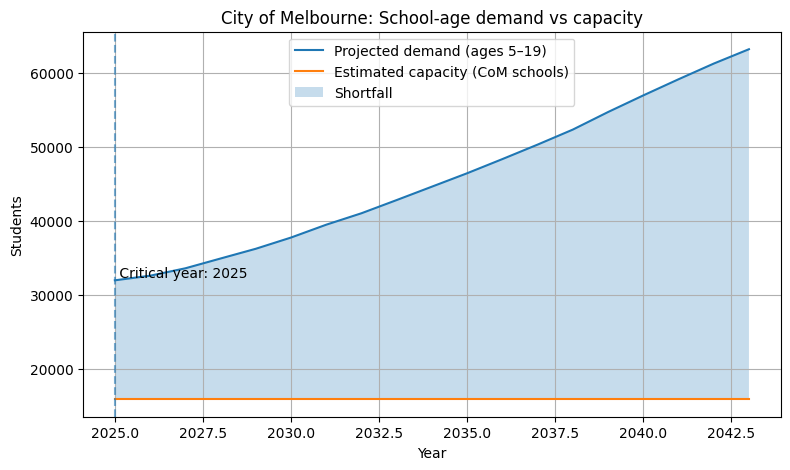

In [120]:
# City of Melbourne demand vs capacity

# Use CoM-only schools for capacity (build if not already made)
try:
    total_capacity = int(schools_com["capacity"].sum())
except NameError:
    # build CoM subset + capacity if not already done
    schools_com = school_df[school_df["lga"].str.strip().eq("Melbourne (C)")].copy()
    def estimate_capacity(t):
        t = str(t).lower()
        if "primary"   in t: return 500
        if "secondary" in t: return 1000
        if "p-12" in t or "pri/sec" in t: return 800
        if "special"   in t: return 200
        return 600
    schools_com["capacity"] = schools_com["school_type"].apply(estimate_capacity)
    total_capacity = int(schools_com["capacity"].sum())

# build table
demand_vs_capacity = city_school_age.copy()       # CoM school-age totals by year
demand_vs_capacity["capacity"] = total_capacity
demand_vs_capacity["gap"] = demand_vs_capacity["school_age_pop"] - demand_vs_capacity["capacity"]

# First year where demand > capacity (if any)
critical_year = (
    demand_vs_capacity.loc[demand_vs_capacity["gap"] > 0, "year"].min()
    if (demand_vs_capacity["gap"] > 0).any() else None
)
print("First year demand exceeds capacity:", critical_year)
display(demand_vs_capacity.head(12))

# plot
plt.figure(figsize=(9,5))
plt.plot(demand_vs_capacity["year"], demand_vs_capacity["school_age_pop"],
         label="Projected demand (ages 5–19)")
plt.plot(demand_vs_capacity["year"], demand_vs_capacity["capacity"],
         label="Estimated capacity (CoM schools)")
plt.fill_between(
    demand_vs_capacity["year"],
    demand_vs_capacity["capacity"],
    demand_vs_capacity["school_age_pop"],
    where=demand_vs_capacity["gap"] > 0,
    alpha=0.25, label="Shortfall"
)
# Mark the critical year on the chart
if critical_year is not None:
    y = demand_vs_capacity.loc[demand_vs_capacity["year"]==critical_year, "school_age_pop"].values[0]
    plt.axvline(critical_year, linestyle="--", alpha=0.6)
    plt.text(critical_year, y, f" Critical year: {critical_year}", va="bottom")

plt.xlabel("Year"); plt.ylabel("Students")
plt.title("City of Melbourne: School-age demand vs capacity")
plt.legend(); plt.grid(True); plt.show()


## Shortfall given as school counts - Primary and Secondary

This converts the annual gap to equivalent school counts by dividing it by ~500 (primary) and ~1000 (secondary), rounding up, and displaying a compact table for planning.

In [121]:
# Copy the year table
dvc = demand_vs_capacity.copy()

# Shortfall = gap but not below zero (no negative shortages)
dvc["shortfall"] = np.maximum(dvc["gap"], 0)

# Convert shortfall into rough school counts
dvc["primary_schools_needed_~500"]   = np.ceil(dvc["shortfall"] / 500).astype(int)
dvc["secondary_schools_needed_~1000"] = np.ceil(dvc["shortfall"] / 1000).astype(int)

# Show the planning table
display(dvc[["year","school_age_pop","capacity","gap",
             "primary_schools_needed_~500","secondary_schools_needed_~1000"]].head(15))


,year,school_age_pop,capacity,gap,primary_schools_needed_~500,secondary_schools_needed_~1000
0,2025,31991,15900,16091,33,17
1,2026,32614,15900,16714,34,17
2,2027,33616,15900,17716,36,18
3,2028,34942,15900,19042,39,20
4,2029,36259,15900,20359,41,21
5,2030,37778,15900,21878,44,22
6,2031,39517,15900,23617,48,24
7,2032,41066,15900,25166,51,26
8,2033,42852,15900,26952,54,27
9,2034,44665,15900,28765,58,29


## Suburban demand-supply gap (Target year)

This cell shows when demand exceeds supply in a particular year. It selects a target year (by default, the most recent), averages the 5-19 population for each suburb to calculate future demand, and standardizes suburb names.

It then adds the capacity of all City of Melbourne schools in each area to generate supply, combines the two tables, and calculates a gap (demand minus supply), treating suburbs without schools as having zero supply. Finally, it ranks suburbs based on the largest positive gaps, resulting in a clear, ordered list of priority sites for more places.


In [122]:
# Use schools_com (CoM schools with capacity) and school_age from earlier cells
TARGET_YEAR = int(school_age["year"].max())

# Demand (ages 5–19) by suburb
suburb_demand = (
    school_age[school_age["year"] == TARGET_YEAR]
    .groupby("area", as_index=False)["school_age_pop"].sum()
    .rename(columns={"area":"suburb", "school_age_pop":"demand_students"})
)

# Supply (sum of school capacities) by suburb
schools_com["suburb"] = schools_com["suburb"].astype(str).str.strip().str.title()
suburb_supply = (
    schools_com.groupby("suburb", as_index=False)["capacity"].sum()
    .rename(columns={"capacity":"supply_capacity"})
)

# Merge and rank gaps
suburb_gap = suburb_demand.merge(suburb_supply, on="suburb", how="left")
suburb_gap["supply_capacity"] = suburb_gap["supply_capacity"].fillna(0)
suburb_gap["gap_students"] = suburb_gap["demand_students"] - suburb_gap["supply_capacity"]
suburb_gap = suburb_gap.sort_values("gap_students", ascending=False)

print(f"Suburb gaps for {TARGET_YEAR} (top 15):")
display(suburb_gap.head(15))


Suburb gaps for 2043 (top 15):


,suburb,demand_students,supply_capacity,gap_students
1,City Of Melbourne,31632,0.0,31632.0
5,Melbourne (Cbd),7688,0.0,7688.0
0,Carlton,4099,1000.0,3099.0
7,North Melbourne,5412,2400.0,3012.0
2,Docklands,2650,500.0,2150.0
11,Southbank,3098,1000.0,2098.0
13,West Melbourne (Residential),1466,0.0,1466.0
8,Parkville,2643,1200.0,1443.0
4,Kensington,3017,2000.0,1017.0
9,Port Melbourne,470,0.0,470.0


## Worst suburb gaps

Plots the top 12 suburbs with the highest gaps (demand - supply) for TARGET_YEAR. Bars indicate pupil deficiency; rotating labels improve reading; and a y-grid and compact structure make the chart simple to scan.

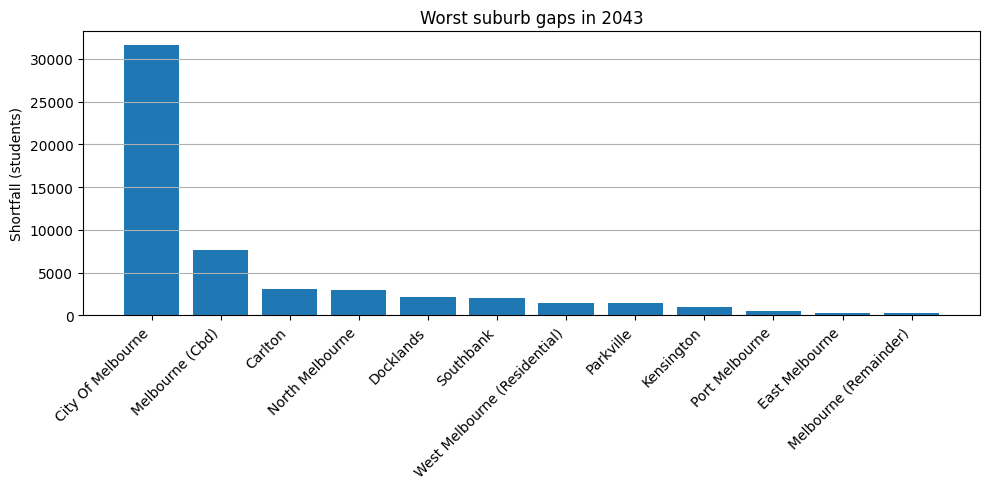

In [123]:
# Plot the top 12 suburbs by student shortfall
top = suburb_gap.head(12)
plt.figure(figsize=(10,5))
plt.bar(top["suburb"], top["gap_students"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Shortfall (students)")
plt.title(f"Worst suburb gaps in {TARGET_YEAR}")
plt.grid(axis="y"); plt.tight_layout(); plt.show()


## Geographic resilience: nearest-school distance and 2 km redundancy

Creates a simple resilience indicator for the City of Melbourne school network. It calculates the great-circle distance to every other school (Haversine), keeps track of the nearest neighbor distance (nearest_km), and counts how many other schools are within 2 kilometers (within2km). It then aggregates these indicators by suburb and combines them with the suburb demand-supply gaps to create a ranked list of high-risk suburbs—those with significant deficits and few close options. This is an O(n²) check, suitable for dozens of schools. Change the redundancy radius to 2.0 if necessary.

In [124]:
# Haversine distance (km) between two lat/lon points
def haversine_km(lat1, lon1, lat2, lon2):
    R = 6371.0088
    p1, p2 = math.radians(lat1), math.radians(lat2)
    dphi = math.radians(lat2-lat1); dl = math.radians(lon2-lon1)
    a = math.sin(dphi/2)**2 + math.cos(p1)*math.cos(p2)*math.sin(dl/2)**2
    return 2*R*math.asin(math.sqrt(a))

# Work on a copy of CoM schools
S = schools_com.reset_index(drop=True).copy()
coords = S[["lat","lon"]].to_numpy()

# For each school: nearest other school distance, and count within 2 km
n = len(S)
nearest = np.full(n, np.nan)
within2 = np.zeros(n, dtype=int)

for i, (la, lo) in enumerate(coords):
    dists = np.array([haversine_km(la, lo, la2, lo2) for la2, lo2 in coords])
    d_ok = dists[dists > 0]
    nearest[i] = d_ok.min() if d_ok.size else np.nan
    within2[i]  = (dists <= 2.0).sum() - 1

S["nearest_km"] = nearest
S["within2km"] = within2

# Aggregate to suburb: average nearest distance and total neighbors within 2 km
suburb_resilience = (S.groupby("suburb", as_index=False)
                       .agg(mean_nearest_km=("nearest_km","mean"),
                            total_neighbors_2km=("within2km","sum")))

# Join with demand gap and rank highest risk
suburb_risk = suburb_gap.merge(suburb_resilience, on="suburb", how="left")
suburb_risk = suburb_risk.sort_values(["gap_students","mean_nearest_km"],
                                      ascending=[False, False])

print("High-risk suburbs (big gap & sparse nearby schools):")
display(suburb_risk.head(12))


High-risk suburbs (big gap & sparse nearby schools):


,suburb,demand_students,supply_capacity,gap_students,mean_nearest_km,total_neighbors_2km
0,City Of Melbourne,31632,0.0,31632.0,NaN,NaN
1,Melbourne (Cbd),7688,0.0,7688.0,NaN,NaN
2,Carlton,4099,1000.0,3099.0,0.721948,15.0
3,North Melbourne,5412,2400.0,3012.0,0.272406,53.0
4,Docklands,2650,500.0,2150.0,1.218590,5.0
5,Southbank,3098,1000.0,2098.0,1.023062,4.0
6,West Melbourne (Residential),1466,0.0,1466.0,NaN,NaN
7,Parkville,2643,1200.0,1443.0,1.144822,11.0
8,Kensington,3017,2000.0,1017.0,0.412441,13.0
9,Port Melbourne,470,0.0,470.0,NaN,NaN


## Scenario - Stage capacity additions

Tests a simple development design by adding extra seats in specific years (via expansions). The increased capacity accumulates over time (cumsum), the deficit is recalculated each year, and the code publishes the critical year (the first year with a shortfall) in this situation. The figure compares baseline demand to current capacity and the scenario capacity line, darkening any residual gap. Adjust the adds dictionary to try alternative plans.

Critical year with scenario: 2025


,year,school_age_pop,extra,capacity,gap
0,2025,31991,0.0,15900.0,16091.0
1,2026,32614,2000.0,17900.0,14714.0
2,2027,33616,0.0,17900.0,15716.0
3,2028,34942,2000.0,19900.0,15042.0
4,2029,36259,0.0,19900.0,16359.0
5,2030,37778,0.0,19900.0,17878.0
6,2031,39517,3000.0,22900.0,16617.0
7,2032,41066,0.0,22900.0,18166.0
8,2033,42852,0.0,22900.0,19952.0
9,2034,44665,0.0,22900.0,21765.0


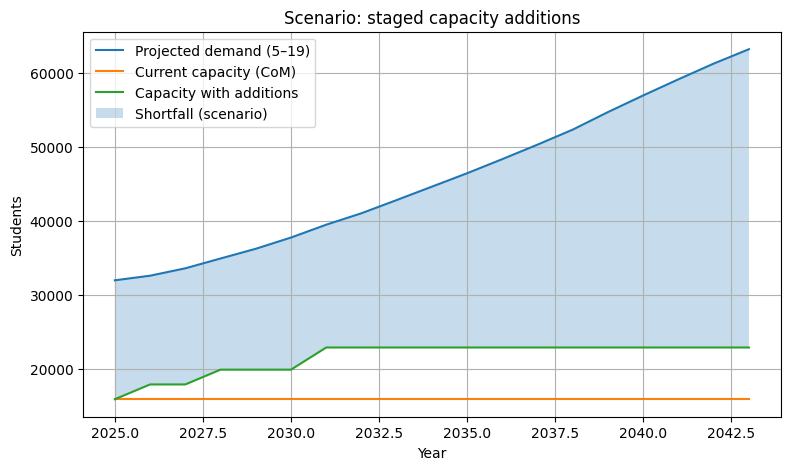

In [125]:
# How many extra seats to add in specific years
additions = {2026: 2000, 2028: 2000, 2031: 3000}  # example plan

# Start from the baseline demand by year
scenario = demand_vs_capacity[["year","school_age_pop"]].copy()
# Start from the baseline demand by year
scenario["extra"] = scenario["year"].map(additions).fillna(0)
# New capacity = current total capacity + cumulative extra seats over time
scenario["capacity"] = total_capacity + scenario["extra"].cumsum()
# Remaining gap each year after applying the additions
scenario["gap"] = scenario["school_age_pop"] - scenario["capacity"]

print("Critical year with scenario:",
      scenario.loc[scenario["gap"]>0, "year"].min())
display(scenario.head(12))

# Plot the scenario vs baseline
plt.figure(figsize=(9,5))
plt.plot(demand_vs_capacity["year"], demand_vs_capacity["school_age_pop"], label="Projected demand (5–19)")
plt.plot(demand_vs_capacity["year"], demand_vs_capacity["capacity"], label="Current capacity (CoM)")
plt.plot(scenario["year"], scenario["capacity"], label="Capacity with additions")
plt.fill_between(scenario["year"], scenario["capacity"], scenario["school_age_pop"],
                 where=scenario["gap"]>0, alpha=0.25, label="Shortfall (scenario)")
plt.xlabel("Year"); plt.ylabel("Students"); plt.title("Scenario: staged capacity additions")
plt.legend(); plt.grid(True); plt.show()


In [126]:
# Total extra seats across all years in the additions plan
total_added = int(scenario["extra"].sum())
# Largest remaining shortfall (after additions) and when it happens
peak_gap_val = int(scenario["gap"].max())
peak_gap_year = int(scenario.loc[scenario["gap"].idxmax(), "year"])

print("Total seats added in plan:", total_added)
print("Peak shortfall:", peak_gap_val, "students")
print("Peak shortfall year:", peak_gap_year)

# Check a specific year (can be changed as needed)
gap_2030 = int(scenario.loc[scenario["year"]==2030, "gap"].iloc[0])
print("Gap in 2030:", gap_2030)


Total seats added in plan: 7000
Peak shortfall: 40365 students
Peak shortfall year: 2043
Gap in 2030: 17878


In [127]:
# Convert the remaining gap into rough school counts per year
need = scenario.copy()
need["shortfall"] = need["gap"].clip(lower=0).astype(int)
# Approximate schools required
need["primary_schools(~500)"]   = need["shortfall"].apply(lambda x: math.ceil(x/500))
need["secondary_schools(~1000)"] = need["shortfall"].apply(lambda x: math.ceil(x/1000))

display(need[["year","shortfall","primary_schools(~500)","secondary_schools(~1000)"]].head(12))


,year,shortfall,primary_schools(~500),secondary_schools(~1000)
0,2025,16091,33,17
1,2026,14714,30,15
2,2027,15716,32,16
3,2028,15042,31,16
4,2029,16359,33,17
5,2030,17878,36,18
6,2031,16617,34,17
7,2032,18166,37,19
8,2033,19952,40,20
9,2034,21765,44,22


##Utilities and Distance Calculation

explains how to compute great-circle distances in kilometers between latitude and longitude points using a vectorized haversine function. This lays the groundwork for subsequent accessibility measurements and catchment analyses, which relate student demand to school proximity.

In [128]:
def haversine_km(lat1, lon1, lat2, lon2):
    """
    Great-circle distance between (lat1, lon1) and (lat2, lon2) in km.
    Supports scalar and array inputs (broadcasting).
    """
    R = 6371.0
    # convert degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    # convert degrees to radians
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    # Haversine formula
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    # arc length on the sphere
    return 2.0 * R * np.arcsin(np.sqrt(a))


##Sensitivity Analysis – Demand Growth vs. Capacity

calculates the resulting shortage by year by projecting school-age demand under various yearly growth rates (0.5%, 1%, 1.5%, and 2%), and comparing it to baseline capacity. The map illustrates how quickly gaps form (or close) across growth assumptions, indicating risk borders where capacity increases would need to speed. The table provides a preview of the scenario outputs.

,year,growth_rate,projected_students,capacity,shortfall
0,2025,0.005,31991.000000,15900.0,16091
1,2026,0.005,32150.955000,17900.0,14250
2,2027,0.005,32311.709775,17900.0,14411
3,2028,0.005,32473.268324,19900.0,12573
4,2029,0.005,32635.634665,19900.0,12735
5,2030,0.005,32798.812839,19900.0,12898
6,2031,0.005,32962.806903,22900.0,10062
7,2032,0.005,33127.620938,22900.0,10227


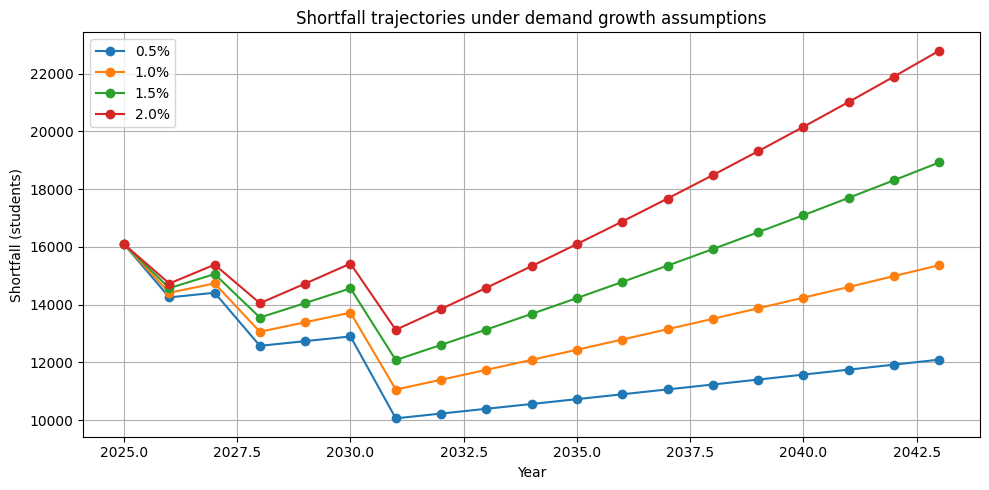

In [129]:
# Sensitivity Analysis

# Build `scenario` from demand_vs_capacity if it doesn't exist
if 'scenario' not in globals():
    if 'demand_vs_capacity' in globals():
        # start from the demand vs capacity table
        scenario = demand_vs_capacity.rename(columns={'demand_students':'school_age_pop'}).copy()
        if 'existing_capacity' not in scenario.columns and 'capacity' in scenario.columns:
            scenario['existing_capacity'] = scenario['capacity']
        if 'existing_capacity' not in scenario.columns:
            scenario['existing_capacity'] = scenario['school_age_pop'].iloc[0]
        if 'added_capacity' not in scenario.columns:
            scenario['added_capacity'] = 0
        scenario['capacity'] = scenario['existing_capacity'] + scenario['added_capacity']
        scenario['gap'] = scenario['school_age_pop'] - scenario['capacity']
    else:
        raise RuntimeError("Cannot build scenarios: expected `scenario` or `demand_vs_capacity`.")

# keep one row per year and sort
base = scenario[['year','school_age_pop','capacity']].drop_duplicates('year').sort_values('year').reset_index(drop=True)


# Test several constant annual growth rates for demand
growth_rates = [0.005, 0.01, 0.015, 0.02]  # 0.5%, 1%, 1.5%, 2%
sens_rows = []
years = base['year'].to_numpy()
y0 = float(base['school_age_pop'].iloc[0])
first_year = int(years[0])

for g in growth_rates:
    projected = np.array([y0 * ((1+g)**int(y-first_year)) for y in years], dtype=float)
    cap = base['capacity'].to_numpy(dtype=float)
    gap = projected - cap
    for y, p, c, gp in zip(years, projected, cap, gap):
        sens_rows.append({'year': int(y), 'growth_rate': g, 'projected_students': float(p),
                          'capacity': float(c), 'shortfall': int(max(0, gp))})

sensitivity = pd.DataFrame(sens_rows)
display(sensitivity.head(8))

# Plot
plt.figure(figsize=(10,5))
for g in growth_rates:
    sub = sensitivity[sensitivity['growth_rate']==g].sort_values('year')
    plt.plot(sub['year'], sub['shortfall'], marker='o', label=f"{int(g*1000)/10}%")
plt.xlabel("Year"); plt.ylabel("Shortfall (students)")
plt.title("Shortfall trajectories under demand growth assumptions")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()


##Translating shortfalls into school units

calculates the approximate number of new schools needed based on expected student shortages:

elementary schools (each with about 500 seats)

Secondary schools (each with about 1000 seats)

This provides policymakers with a clear, concrete picture of how demand shortages eventually result in infrastructure requirements.


In [130]:
# Planning Table
# Start from the sensitivity results
planning = sensitivity.copy()

# Convert student shortfall into approximate number of schools needed
# Assumptions made
#   - One primary school ≈ 500 seats
#   - One secondary school ≈ 1,000 seats
planning['primary_schools(~500)']    = np.ceil(planning['shortfall']/500).astype(int)
planning['secondary_schools(~1000)'] = np.ceil(planning['shortfall']/1000).astype(int)
display(planning.head(10))


,year,growth_rate,projected_students,capacity,shortfall,primary_schools(~500),secondary_schools(~1000)
0,2025,0.005,31991.000000,15900.0,16091,33,17
1,2026,0.005,32150.955000,17900.0,14250,29,15
2,2027,0.005,32311.709775,17900.0,14411,29,15
3,2028,0.005,32473.268324,19900.0,12573,26,13
4,2029,0.005,32635.634665,19900.0,12735,26,13
5,2030,0.005,32798.812839,19900.0,12898,26,13
6,2031,0.005,32962.806903,22900.0,10062,21,11
7,2032,0.005,33127.620938,22900.0,10227,21,11
8,2033,0.005,33293.259042,22900.0,10393,21,11
9,2034,0.005,33459.725337,22900.0,10559,22,11


##Surb risk from network sparsity
calculates the nearest-neighbor distance (km) for each school and averages it by suburb to get mean_nearest_km, a statistic for accessibility at the suburb level. Suburban_risk is created by combining this with demand/gap data. In order to prioritize areas where additional capacity would most improve access, suburbs with wider gaps and longer mean distances are marked as higher risk.

In [131]:
# Build `suburb_risk` if required
# Requires: suburb_gap (suburb, gap_students, optionally demand_students), schools_com (lat, lon, suburb)
if 'suburb_risk' not in globals():
    if 'suburb_gap' in globals() and 'schools_com' in globals():
        sc = schools_com.copy()
        sg = suburb_gap.copy()

        # nearest-neighbour distance for each school (km)
        lat = sc['lat'].to_numpy(dtype=float)
        lon = sc['lon'].to_numpy(dtype=float)
        n = len(sc)
        nearest = np.full(n, np.nan)
        for i in range(n):
            # Distance from school i to every school
            d = haversine_km(lat[i], lon[i], lat, lon)
            d[i] = np.inf
            nearest[i] = np.min(d)

        # Attach nearest distance to each school
        sc_nn = sc.copy()
        sc_nn['nearest_km'] = nearest

        # suburb-level access proxy
        access = sc_nn.groupby('suburb', as_index=False)['nearest_km'].mean().rename(columns={'nearest_km':'mean_nearest_km'})
        suburb_risk = sg.merge(access, on='suburb', how='left')

        # fill suburbs without schools with a high penalty (90th percentile or 3 km)
        fallback = np.nanpercentile(access['mean_nearest_km'], 90) if access['mean_nearest_km'].notna().any() else 3.0
        suburb_risk['mean_nearest_km'] = suburb_risk['mean_nearest_km'].fillna(fallback)
    else:
        print("Cannot construct `suburb_risk`: need `suburb_gap` and `schools_com`.")


## Coverage Inequality Across Suburbs
provides an equity lens on provision by calculating the capacity ratio (served ÷ demand) for each suburb and using the Gini coefficient to summarize inequity. Then, the suburbs are categorized into well-served (top 20%) and underserved (bottom 20%) cohorts, showing where capacity is relatively plentiful and where access is most limited.

In [132]:
# Equity access and metrics
def gini(x):
    x = np.asarray(x, dtype=float).flatten()

    # shift up if any negatives (Gini expects non-negative)
    if np.amin(x) < 0: x = x - np.amin(x)
    x = x + 1e-9     # Tiny epsilon to avoid division by zero
    x = np.sort(x)   # Sort ascending
    n = x.size
    idx = np.arange(1, n+1)
    return np.sum((2*idx - n - 1) * x) / (n * np.sum(x))

equity_df = None
# Suburb-level gaps are needed to assess equity
if 'suburb_gap' in globals():
    eq = suburb_gap.copy()
    # If we have both demand and capacity, compute coverage = capacity / demand
    if {'demand_students','capacity'}.issubset(eq.columns):
        eq['capacity_ratio'] = (eq['capacity'] / eq['demand_students']).replace([np.inf, -np.inf], np.nan)
    # If we have demand and gap, compute coverage = (demand - gap) / demand
    elif {'gap_students','demand_students'}.issubset(eq.columns):
        eq['capacity_ratio'] = ((eq['demand_students'] - eq['gap_students']) / eq['demand_students']).replace([np.inf, -np.inf], np.nan)
    # Fallback: derive a rough coverage from the gap alone (normalized)
    else:
        m = eq['gap_students'].max() if 'gap_students' in eq.columns else 1.0
        eq['capacity_ratio'] = 1 - (eq.get('gap_students', pd.Series([0]*len(eq))) / max(m, 1.0))
    # Keep values in a reasonable range
    eq['capacity_ratio'] = eq['capacity_ratio'].clip(lower=0, upper=2)
    equity_df = eq[['suburb','capacity_ratio']].dropna().reset_index(drop=True)

# If we have a valid table, report inequality and show extremes
if equity_df is not None and len(equity_df) > 0:
    gi = gini(equity_df['capacity_ratio'])
    print(f"Gini coefficient of capacity coverage across suburbs: {gi:.3f}")
     # Rank suburbs from lowest coverage (underserved) to highest (well-served)
    equity_df['pct_rank'] = equity_df['capacity_ratio'].rank(pct=True, method='average')
    print("\nUnderserved (bottom 20%):")
    display(equity_df[equity_df['pct_rank']<=0.2].sort_values('capacity_ratio').head(10))
    print("\nWell-served (top 20%):")
    display(equity_df[equity_df['pct_rank']>=0.8].sort_values('capacity_ratio', ascending=False).head(10))
else:
    print("Equity analysis skipped: `suburb_gap` missing or lacks needed columns.")


Gini coefficient of capacity coverage across suburbs: 0.690

Underserved (bottom 20%):


,suburb,capacity_ratio,pct_rank



Well-served (top 20%):


,suburb,capacity_ratio,pct_rank
12,South Yarra,2.00000,1.000000
8,Kensington,0.66291,0.923077
7,Parkville,0.45403,0.846154


##

## Accessibility by Travel Radius

calculates service coverage by suburb using various travel-distance hypotheses. The code determines a basic coverage fraction for each suburb centroid by counting the number of schools that are within 1, 2, 3, and 5 km. It then reports (1) the average coverage at each radius for the whole area and (2) the worst-served suburbs at 2 km, revealing how sensitive accessibility is to catchment size and where proximity constraints are most acute.

In [133]:
# Catchment Radius Sensitivity (Proximity based)
# Estimates coverage by counting how many schools lie within R km of each suburb centroid
if 'schools_com' in globals() and 'suburb_gap' in globals():
    sc = schools_com.copy()
    sg = suburb_gap.copy()

    # Suburb centroids from school points, fallback to overall mean if needed
    if {'suburb','lat','lon'}.issubset(sc.columns) and sc['suburb'].notna().any():
        centroids = sc.groupby('suburb', as_index=False)[['lat','lon']].mean()
    else:
        centroids = pd.DataFrame({'suburb': sg['suburb'].unique(),
                                  'lat': np.full(sg['suburb'].nunique(), sc['lat'].mean()),
                                  'lon': np.full(sg['suburb'].nunique(), sc['lon'].mean())})
    sgc = sg.merge(centroids, on='suburb', how='left').dropna(subset=['lat','lon'])

    school_xy = sc[['lat','lon']].to_numpy(dtype=float)
    radii = [1, 2, 3, 5]  # km
    rows = []
    for _, r in sgc.iterrows():
        la, lo = float(r['lat']), float(r['lon'])
        dists = haversine_km(la, lo, school_xy[:,0], school_xy[:,1])  # vectorized
        for R in radii:
            nearby = int((dists <= R).sum())
            # Simple coverage proxy - assume "good" coverage at ~3 nearby schools
            coverage_fraction = min(1.0, nearby / 3.0)  # tune as needed
            rows.append({'suburb': r['suburb'], 'radius_km': R,
                         'nearby_schools': nearby, 'coverage_fraction': coverage_fraction,
                         'gap_students': r.get('gap_students', np.nan),
                         'demand_students': r.get('demand_students', np.nan)})

    catchment_df = pd.DataFrame(rows)

    # Summary - average coverage by radius
    print("Average coverage by radius:")
    display(catchment_df.groupby('radius_km')['coverage_fraction'].mean().rename('avg_coverage').reset_index())
    # Worst suburbs at 2 km radius
    print("\nWorst coverage at 2 km:")
    display(catchment_df[catchment_df['radius_km']==2].sort_values('coverage_fraction').head(10)[
        ['suburb','nearby_schools','coverage_fraction','gap_students','demand_students']
    ])
else:
    print("Catchment sensitivity skipped: need `schools_com` and `suburb_gap`.")


Average coverage by radius:


,radius_km,avg_coverage
0,1,0.666667
1,2,1.000000
2,3,1.000000
3,5,1.000000



Worst coverage at 2 km:


,suburb,nearby_schools,coverage_fraction,gap_students,demand_students
1,Carlton,8,1.0,3099.0,4099
5,North Melbourne,12,1.0,3012.0,5412
9,Docklands,6,1.0,2150.0,2650
13,Southbank,5,1.0,2098.0,3098
17,Parkville,7,1.0,1443.0,2643
21,Kensington,5,1.0,1017.0,3017
25,South Yarra,7,1.0,-1221.0,579


## Risk and Priority – Combining Demand Gaps with Accessibility
multiplies the student shortage in each suburb by the average distance to the closest school to get a risk index. Suburbs with inadequate access and wide gaps rank highest on the ranking. The scatter plot illustrates the relationship between demand gap and access distance (bubble size ∝ gap), indicating where additional school capacity would have the most impact. The table lists the ten suburbs that are at the highest risk.

Top 10 risk / priority suburbs (cleaned):


,suburb,gap_students,mean_nearest_km,risk_index
0,Melbourne (Cbd),7688.0,1.174329,16716.242337
1,Carlton,3099.0,0.721948,5336.316969
2,Docklands,2150.0,1.218590,4769.968716
3,Southbank,2098.0,1.023062,4244.384025
4,North Melbourne,3012.0,0.272406,3832.486586
5,West Melbourne (Residential),1466.0,1.174329,3187.566502
6,Parkville,1443.0,1.144822,3094.977876
7,Kensington,1017.0,0.412441,1436.452910
8,Port Melbourne,470.0,1.174329,1021.934690
9,East Melbourne,270.0,1.174329,587.068865


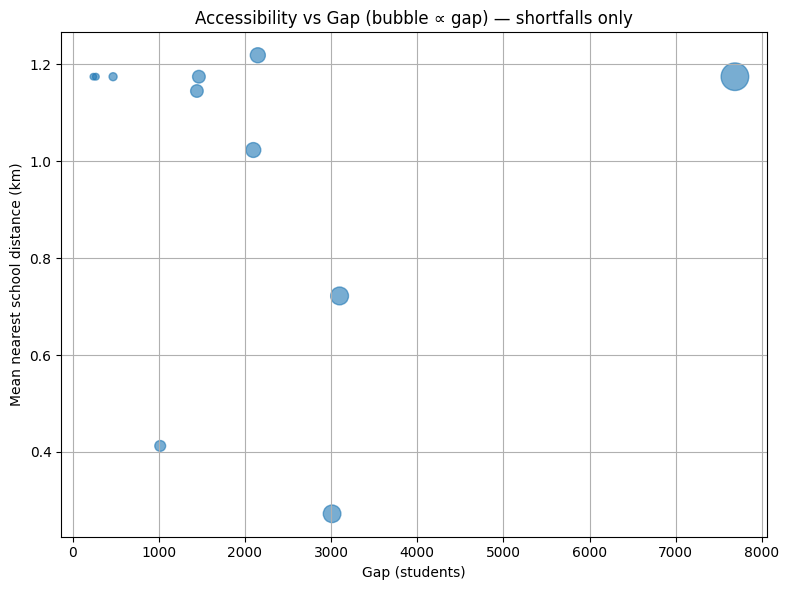

In [134]:
# Risk / Priority View (cleaned: GAP × ACCESS)
if 'suburb_risk' in globals():
    risk = suburb_risk.copy()

    # Drop obvious aggregates that can distort suburb analysis
    bad_names = {"City Of Melbourne"}  # add others if needed
    risk = risk[~risk['suburb'].isin(bad_names)].copy()

    # Fill missing access with a conservative fallback (90th pct or 3km)
    if risk['mean_nearest_km'].notna().any():
        fallback = float(np.nanpercentile(risk['mean_nearest_km'], 90))
    else:
        fallback = 3.0
    risk['mean_nearest_km'] = risk['mean_nearest_km'].fillna(fallback)

    # Only consider real shortfalls; over-capacity shouldn't get priority
    risk['gap_pos'] = risk['gap_students'].clip(lower=0)

    # Risk score: bigger gaps and longer travel results in higher priority
    risk['risk_index'] = risk['gap_pos'] * (1.0 + risk['mean_nearest_km'])

    # Rank & show
    ranked = (risk.sort_values('risk_index', ascending=False)
                   [['suburb','gap_students','mean_nearest_km','risk_index']]
                   .reset_index(drop=True))

    print("Top 10 risk / priority suburbs (cleaned):")
    display(ranked.head(10))

    # Plot only true shortfalls
    plot_df = ranked[ranked['gap_students'] > 0].copy()
    plt.figure(figsize=(8,6))
    plt.scatter(plot_df['gap_students'], plot_df['mean_nearest_km'],
                s=10 + (plot_df['gap_students']*0.05), alpha=0.6)
    plt.xlabel("Gap (students)")
    plt.ylabel("Mean nearest school distance (km)")
    plt.title("Accessibility vs Gap (bubble ∝ gap) — shortfalls only")
    plt.grid(True); plt.tight_layout(); plt.show()
else:
    print("Risk view skipped: `suburb_risk` not available.")


##Fairness-Aware Allocation: Setting Priorities for Capacity Addition
In this step, a clear, priority-based rule is used to allocate new school seats among the suburbs. Every round, we allocate a set number of seats (say 3,000) to the 1,000- or 500-seat schools that do the best. The priority score for a suburb is score = gap_students × (1 + α × mean_nearest_km) (α = 0.5), meaning that places with significant gaps and limited access to schools rank highest. We limit the number of schools in each suburb, impose diminishing returns when more schools are located in the same suburb, and disqualify the entire "City of Melbourne" row in order to maintain realism.

In [135]:
# config
ROUND_COUNT = 20                 # how many passes
SEATS_PER_ROUND = 3000           # budget per round (tweak)
SCHOOL_SIZES = [1000, 500]       # available builds
ALPHA = 0.5                      # access weight in the score
MAX_SCHOOLS_PER_SUBURB = 6       # hard cap
EXCLUDE = {"City Of Melbourne"}  # LGA aggregate to exclude if present

# base tables
alloc = suburb_gap[['suburb','gap_students']].copy()
alloc = alloc[~alloc['suburb'].isin(EXCLUDE)].reset_index(drop=True)
alloc['allocated_seats'] = 0
alloc['schools_built'] = 0

# access proxy
access_map = {}
if 'suburb_risk' in globals() and 'mean_nearest_km' in suburb_risk.columns:
    access_map = suburb_risk.set_index('suburb')['mean_nearest_km'].to_dict()
alloc['mean_nearest_km'] = alloc['suburb'].map(access_map).fillna(0.0)

steps = []
for r in range(1, ROUND_COUNT+1):
    round_budget = SEATS_PER_ROUND
    # keep allocating until we spend this round’s budget or run out of need
    while round_budget > 0 and alloc['gap_students'].gt(0).any():
        damp = 1 + 0.2 * alloc['schools_built']
        scores = (alloc['gap_students'] * (1 + ALPHA*alloc['mean_nearest_km'])) / damp

        # mask: only suburbs under cap and still in need
        mask = (alloc['gap_students'] > 0) & (alloc['schools_built'] < MAX_SCHOOLS_PER_SUBURB)
        if not scores[mask].any():
            break

        idx = scores[mask].idxmax()
        need_here = int(alloc.loc[idx, 'gap_students'])

        # pick feasible size that fits budget (prefer larger if possible)
        size = SCHOOL_SIZES[0] if (need_here >= 750 and round_budget >= SCHOOL_SIZES[0]) else \
               SCHOOL_SIZES[1] if (round_budget >= SCHOOL_SIZES[1]) else 0
        if size == 0:
            break  # budget too small to place any school this round

        # apply
        alloc.loc[idx, 'allocated_seats'] += size
        alloc.loc[idx, 'schools_built']   += 1
        alloc.loc[idx, 'gap_students']     = max(0, need_here - size)
        round_budget -= size

        steps.append({
            'round': r,
            'suburb': alloc.loc[idx, 'suburb'],
            'school_size': size,
            'remaining_gap_here': int(alloc.loc[idx, 'gap_students']),
            'schools_built_here': int(alloc.loc[idx, 'schools_built'])
        })

allocation_steps = pd.DataFrame(steps)
print("Sample of placement log:")
display(allocation_steps.head(15))

summary_alloc = alloc.sort_values(['allocated_seats','gap_students'], ascending=[False, True])
summary_alloc['~500_schools_equiv'] = (summary_alloc['allocated_seats'] // 500).astype(int)

print("\nAllocation summary (top 15):")
display(summary_alloc.head(15))


Sample of placement log:


,round,suburb,school_size,remaining_gap_here,schools_built_here
0,1,Melbourne (Cbd),1000,6688,1
1,1,Melbourne (Cbd),1000,5688,2
2,1,Carlton,1000,2099,1
3,2,Melbourne (Cbd),1000,4688,3
4,2,Docklands,1000,1150,1
5,2,North Melbourne,1000,2012,1
6,3,Southbank,1000,1098,1
7,3,Melbourne (Cbd),1000,3688,4
8,3,Carlton,1000,1099,2
9,4,Parkville,1000,443,1



Allocation summary (top 15):


,suburb,gap_students,allocated_seats,schools_built,mean_nearest_km,~500_schools_equiv
0,Melbourne (Cbd),1688.0,6000,6,0.000000,12
1,Carlton,0.0,3500,4,0.721948,7
2,North Melbourne,0.0,3500,4,0.272406,7
3,Docklands,0.0,2500,3,1.218590,5
4,Southbank,0.0,2500,3,1.023062,5
5,West Melbourne (Residential),0.0,1500,2,0.000000,3
6,Parkville,0.0,1500,2,1.144822,3
7,Kensington,0.0,1500,2,0.412441,3
8,Port Melbourne,0.0,500,1,0.000000,1
9,East Melbourne,0.0,500,1,0.000000,1


##Backlog Over Time and Cumulative Unmet Demand
Monitors the annual accumulation of unmet student demand when capacity increases fall short of population growth. It is evident how little annual gaps pile up to a significant deficit if they are not addressed since the deficiency for each year is added up to create a cumulative backlog. This accumulation is illustrated in the line chart, which highlights the need for prompt interventions.

,year,shortfall,cumulative_unmet
0,2025,16091.0,16091.0
1,2026,14714.0,30805.0
2,2027,15716.0,46521.0
3,2028,15042.0,61563.0
4,2029,16359.0,77922.0
5,2030,17878.0,95800.0
6,2031,16617.0,112417.0
7,2032,18166.0,130583.0
8,2033,19952.0,150535.0
9,2034,21765.0,172300.0


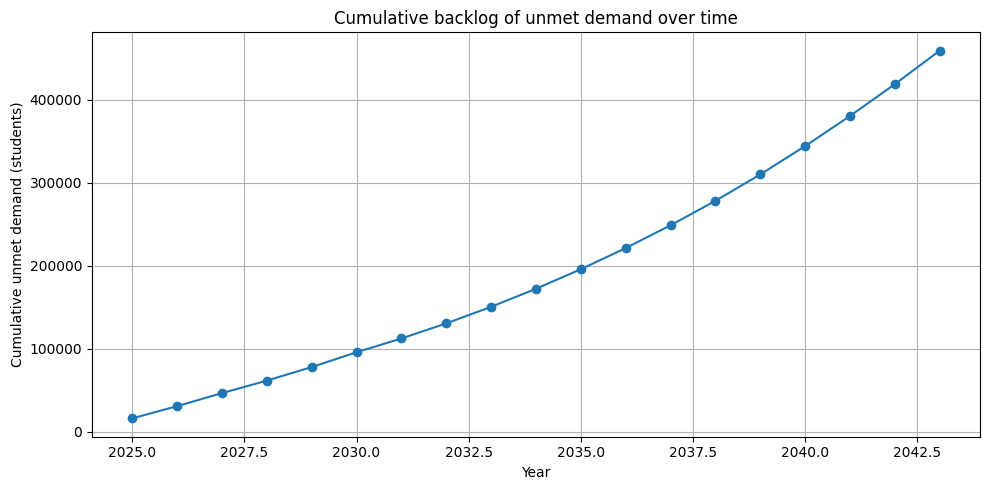

In [136]:
# Cumulative Unmet Demand
if 'scenario' in globals():
    unmet = scenario.copy()
    unmet['shortfall'] = unmet['gap'].clip(lower=0)
    unmet['cumulative_unmet'] = unmet['shortfall'].cumsum()
    display(unmet[['year','shortfall','cumulative_unmet']].head(12))

    plt.figure(figsize=(10,5))
    plt.plot(unmet['year'], unmet['cumulative_unmet'], marker='o')
    plt.xlabel("Year"); plt.ylabel("Cumulative unmet demand (students)")
    plt.title("Cumulative backlog of unmet demand over time")
    plt.grid(True); plt.tight_layout(); plt.show()
else:
    print("Scenario data not available for backlog plot.")


##Comparing Capacity-Addition Plans through a Stress Test
Adds seats in predetermined years and tracks the capacity and gap over time to simulate different build-out timelines (e.g., Plan A vs. Plan B). This illustrates how the timing and magnitude of investments alter the trajectory of the shortfall, assisting in the selection of a strategy that minimizes gaps while mitigating delivery and budgetary risks.

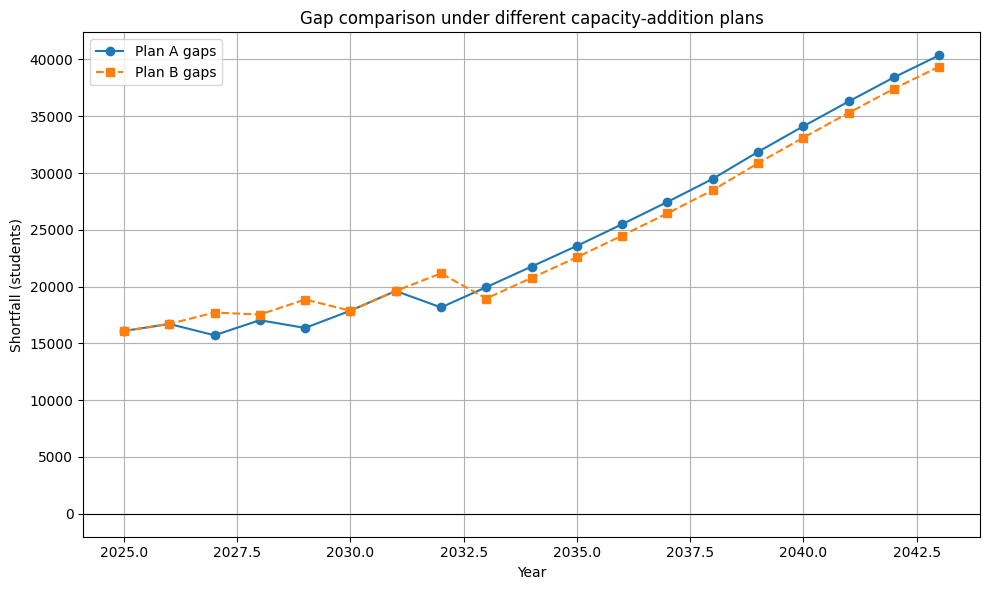

In [137]:
# Scenario Stress Test
# Define baseline total_capacity
if 'total_capacity' not in globals():
    if 'scenario' in globals() and 'capacity' in scenario.columns:
        total_capacity = float(scenario.sort_values('year')['capacity'].iloc[0])
    elif 'demand_vs_capacity' in globals() and 'capacity' in demand_vs_capacity.columns:
        total_capacity = float(demand_vs_capacity.sort_values('year')['capacity'].iloc[0])
    else:
        if 'demand_vs_capacity' in globals():
            total_capacity = float(demand_vs_capacity.sort_values('year')['school_age_pop'].iloc[0])
        else:
            raise RuntimeError("Define `total_capacity` or provide `scenario`/`demand_vs_capacity` with capacity.")

def run_capacity_plan(additions_dict, demand_frame=None):
    """Return a DataFrame with gap under a given additions plan."""
    df = (demand_frame if demand_frame is not None else demand_vs_capacity).copy()
    if 'school_age_pop' not in df.columns and 'demand_students' in df.columns:
        df = df.rename(columns={'demand_students':'school_age_pop'})
    sc = df[['year','school_age_pop']].drop_duplicates('year').sort_values('year').reset_index(drop=True)
    sc['extra'] = sc['year'].map(additions_dict).fillna(0).astype(float)
    sc['capacity'] = total_capacity + sc['extra'].cumsum()
    sc['gap'] = sc['school_age_pop'] - sc['capacity']
    return sc

# Example plans aligned to the base years
years_base = base['year'].to_numpy()
plan_A = {int(years_base[0])+2:2000, int(years_base[0])+4:2000, int(years_base[0])+7:3000}
plan_B = {int(years_base[0])+3:1500, int(years_base[0])+5:2500, int(years_base[0])+8:4000}

scA = run_capacity_plan(plan_A, demand_frame=base)
scB = run_capacity_plan(plan_B, demand_frame=base)

plt.figure(figsize=(10,6))
plt.plot(scA['year'], scA['gap'], marker='o', label="Plan A gaps")
plt.plot(scB['year'], scB['gap'], marker='s', label="Plan B gaps", linestyle="--")
plt.axhline(0, color='k', linewidth=0.8)
plt.xlabel("Year"); plt.ylabel("Shortfall (students)")
plt.title("Gap comparison under different capacity-addition plans")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()


## Visual Check: Less than 1% Shortfall Trajectory Development
The planning table's 1% annual growth assumption is taken out, and the shortfall trend is plotted over time. By demonstrating how demand gaps change under the assumption of moderate development, this gives policymakers a baseline case against which other scenarios or measures can be evaluated.

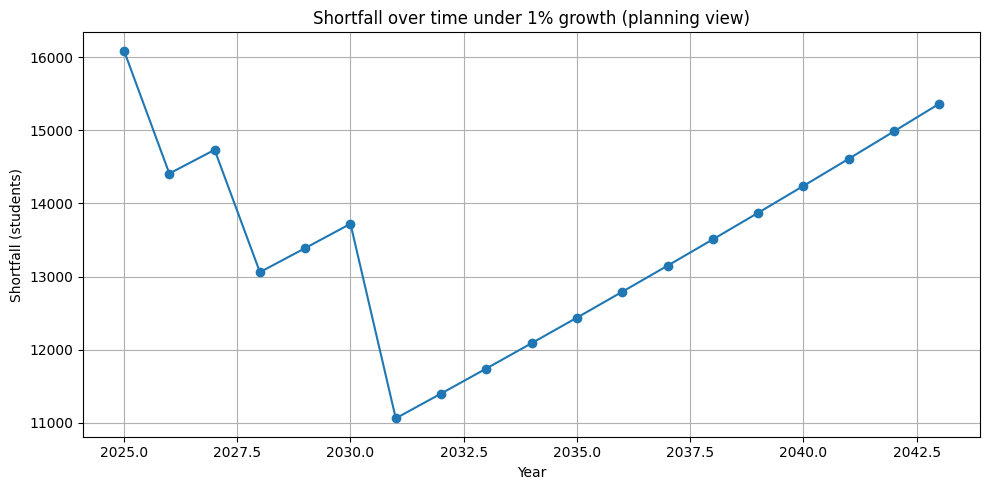

In [138]:
# Visual: Shortfall Trajectory (1% growth slice)
if 'planning' in globals():
    sel = planning[(planning['growth_rate']==0.01)].sort_values('year')
    plt.figure(figsize=(10,5))
    plt.plot(sel['year'], sel['shortfall'], marker='o')
    plt.xlabel("Year"); plt.ylabel("Shortfall (students)")
    plt.title("Shortfall over time under 1% growth (planning view)")
    plt.grid(True); plt.tight_layout(); plt.show()
else:
    print("Planning table not available; run sensitivity cell first.")
